# Title

## Table of Content
* ...
* ...


## Abstarct
* 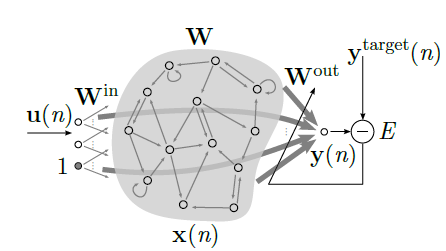...
* Background knowledge
* Purpose
* Script (Project) flow

## Reference
Lukoševičius, M. (2012). A practical guide to applying echo state
networks. In Neural networks: Tricks of the trade (pp. 659-686).
Springer, Berlin, Heidelberg. (Link)

## Dataset description
* ...

## Behind scene: Echo neural network

## Note
* Description of the dataset is needed
* python start from 0 and matlab start from 1 (therefore, index number might be different)
* how do we set minpeakdist?
* Skip TW and TWE ?
* Script flow at the beginning is needed
* Don't understand what is F and X in dataset

## Load matlab files

In [7]:
### Download relevent module
#!pip install numpy
#!pip install python-math
#!pip install scipy
#!pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 11.3 MB/s eta 0:00:00
     ---------------------------------------- 163.0/163.0 kB ? eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 12.7 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 13.2 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
### import relevant module
import numpy as np
import sys  
import mat_to_python
import pickle
import os
from scipy.signal import find_peaks
import math
from scipy.sparse import random
import copy
import scipy
import matplotlib.pyplot as plt

In [4]:
import scipy.sparse as sp

def sprandn(n, m, density):
    size = int(n * m * density)
    data = np.random.normal(size=size)
    indices = np.random.choice(n, size=size), np.random.choice(m, size=size)
    return sp.coo_matrix((data, indices), shape=(n, m)).tocsr()

In [11]:
### Initial setting
subj = 2 # which subject to run the script for

### Data Preparation
# Load Data
folder = "Data" # folder where all data is stored
targated_subject = "P0{}".format(str(subj)) # get a list of all .mat files in the (sub)folders - now only for one subject
targeted_path = folder + "/" + targated_subject
filenames = []
filefolders = []
for filename in os.listdir(targeted_path):
  filenames.append(filename) # extract the names of the files
  filefolders.append(targeted_path) # extract location
nFiles = len(filenames) #how many files are there
data = []
for current_file in filenames: # loop over filename
  load_current_file = mat_to_python.loadmat(targeted_path+"/"+current_file) # load current file
  data.append(load_current_file)

(0.0, 4.759)

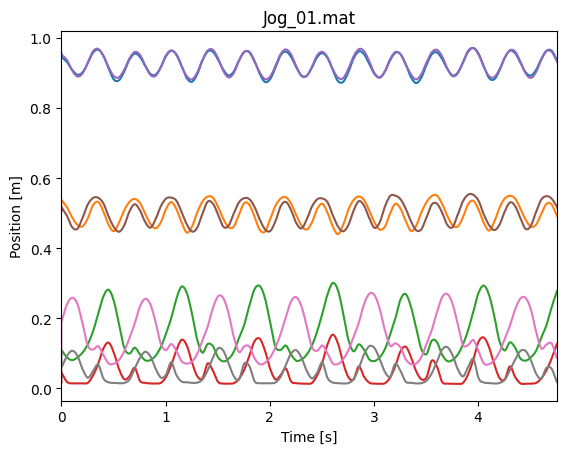

In [13]:
### Visualize Data
# legend information is missing

plotFile = 0 # which file to plot
fig = plt.figure()
plt.plot(data[plotFile]["t"], data[plotFile]["pos_z"])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title(filenames[plotFile][4:])
plt.xlim(data[plotFile]["t"][0], data[plotFile]["t"][-1])

## Data processing

### Create input and target output data for the network

*  Here, we create the input and target output data.
* We will have two inputs:
  1. A sinusoid at the desired locomotor frequency
  2. A constant input specifying the activity (Walk =1, TW = 2 (tandem walking), TWE = 3 (tandem walking, eyes closed), Jog = 4).

* The target output is the kinematic data in z-direction (vertical). 

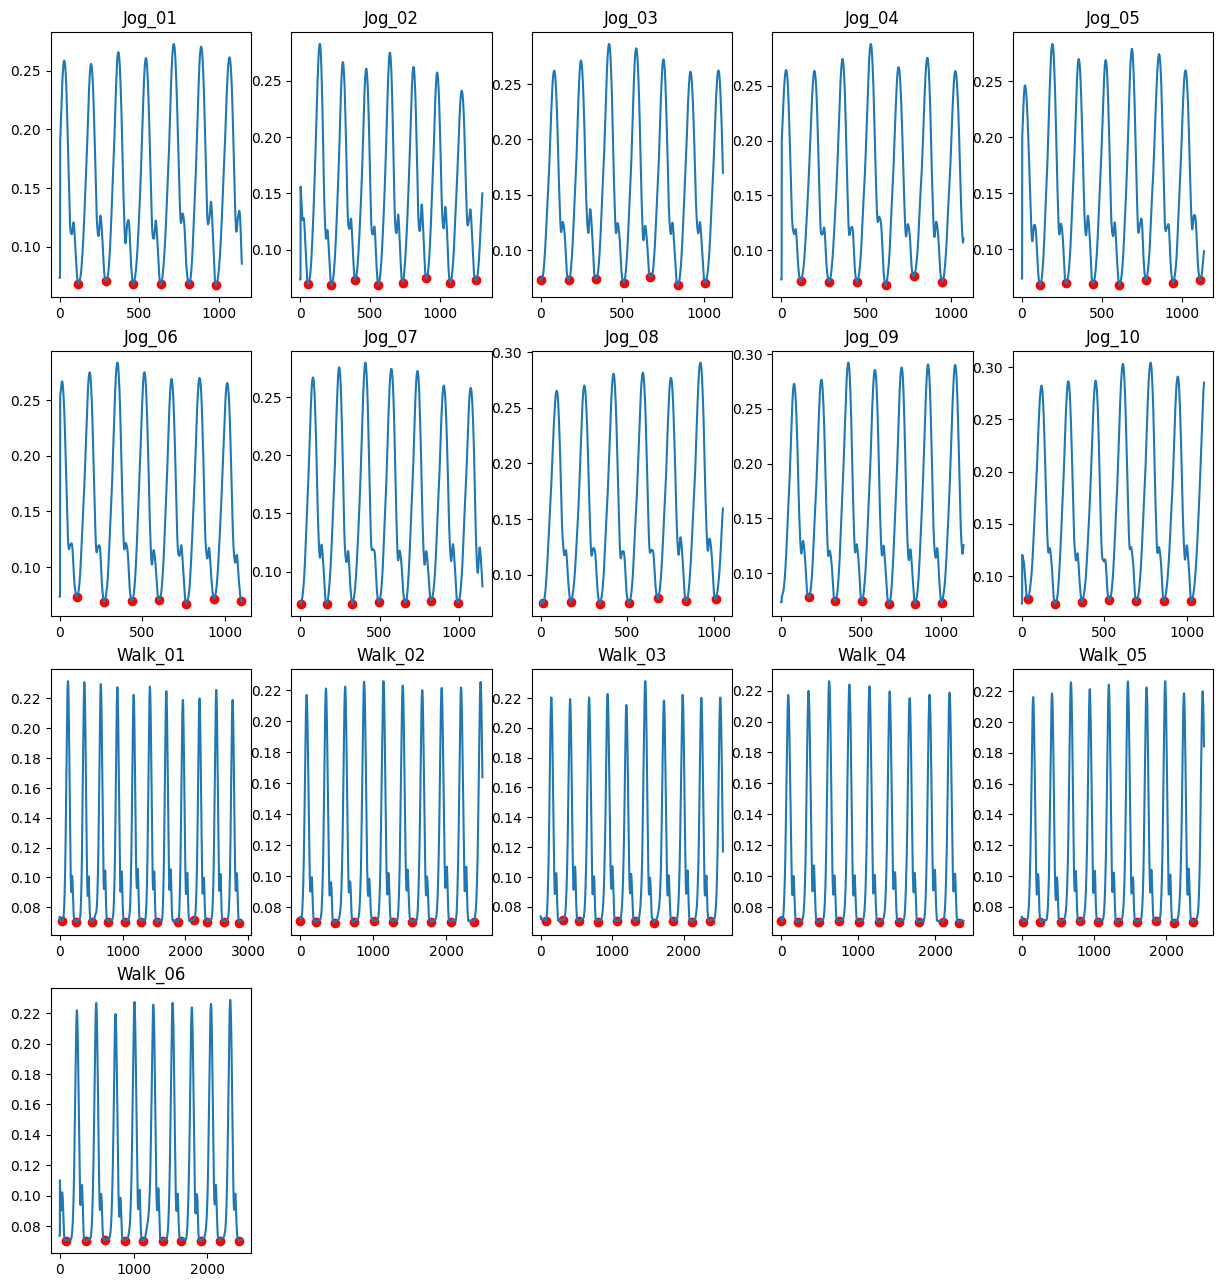

In [43]:
nFiles = len(filenames)
dataset = []
plot_pos = 1
fig = plt.figure(figsize = (15,20))
for iFile in range(nFiles): # loop over filenames
  #iFile = 12 jog_1
  if 'Walk' in data[iFile]['taskname']:
    actnr = 1
    minpeakdist = 200
    
  elif 'TW' in data[iFile]['taskname']:
    actnr = 2
    minpeakdist = 300
    dataset.append([])
    continue
    
  elif 'TWE' in data[iFile]['taskname']:
    actnr = 3
    minpeakdist = 300
    dataset.append([])
    continue
    
    
  elif 'Jog' in data[iFile]['taskname']:
    actnr = 4
    minpeakdist = 150

  # we don't want any sudden/unrealist transitions, so we cut the data at each left heelstrike
  footmarker = data[iFile]["pos_z"][:,np.where(data[iFile]["markernames"]=='LeftFoot')[0][0]] # get the left foot marker data
  peaks, vals = find_peaks(0-footmarker, distance=minpeakdist) # plot to check we found (only) the correct peaks

  plt.subplot(5, 5, plot_pos)
  plt.plot(footmarker)
  plt.scatter(peaks, footmarker[peaks], marker = "o", color = 'red')
  plt.title(data[iFile]['taskname'])
  plot_pos = plot_pos +1

####################################################################################################################################################
################################################### This part might need more explanation ##########################################################
####################################################################################################################################################

  fs = np.mean(1/np.diff(data[iFile]['t'][peaks[0]:peaks[-2]])) # get the sampling frequency from the time difference between samples
  target_time_F_X_structure = {}
  target_time_F_X_structure["Ytarget"] = data[iFile]["pos_z"][peaks[0]:peaks[-1],:] # make all cycles between the first and last heelstrike the target output
  target_time_F_X_structure["t"] = data[iFile]["t"][peaks[0]:peaks[-1]] # corresponding time
  
  LHS = np.array(peaks) - peaks[0]+1 # correct the indices where heel strikes happen, now that we have excluded the first samples

  diffLHS = np.diff(LHS) # stride lengths in samples

  X = np.empty((2, target_time_F_X_structure["t"].shape[0]), dtype=object) # initialize a array
  for iLHS in range(len(LHS)-1): # for each stride
    indx = range(LHS[iLHS]-1, LHS[iLHS+1]-1) # get the sample index
    target_time_F_X_structure["F"] = 1/(diffLHS[iLHS]/fs)*2*math.pi # calculate the stride frequency
    
    X[0,indx] = np.sin(target_time_F_X_structure["F"]*(target_time_F_X_structure["t"][indx] - target_time_F_X_structure["t"][indx[0]])) # make the input a sinusoid with that frequency
    target_time_F_X_structure["X"] = X

  X[1,:] = np.ones(target_time_F_X_structure["t"].shape)*actnr/4 # make the second output a constant with the value indicating the activity & scale it to be between 0 and 1
  dataset.append(target_time_F_X_structure)

####################################################################################################################################################
####################################################################################################################################################
####################################################################################################################################################


In [15]:
dataset[3]["t"].shape

(837,)

### Split Data in Train and Test set

In [16]:
fracTrain = 0.7 # fraction of data to go in training set
indTrain = np.random.choice(nFiles, round(0.7*nFiles), replace = False) # randomly select fracTrain percent of the files to be in the training set
inTest = np.array(range(nFiles))[np.isin(list(range(nFiles)), indTrain, invert=True)] # all other files go in the test set

In [17]:
### testing enviroment
#indTrain = [0,1,2]
#inTest = [3,5]

### Creat Train and Test signal

In [18]:
sigTrain = {}
Ytarget_list = []
t_list = []
F_list = []
X_list_1 = []
X_list_2 = []
for targeted_train_indx in indTrain:
  try:
    Ytarget_list.append(dataset[targeted_train_indx]["Ytarget"])
    t_list.append(dataset[targeted_train_indx]["t"])
    F_list.append(dataset[targeted_train_indx]["F"])
    X_list_1.append(dataset[targeted_train_indx]["X"][0,:])
    X_list_2.append(dataset[targeted_train_indx]["X"][1,:])
  except:
    continue
sigTrain["Ytarget"] = (np.concatenate(Ytarget_list, axis=0))
sigTrain["t"] = (np.concatenate(t_list, axis=0))
sigTrain["F"] = np.array(F_list)
X_list_1 = np.concatenate(X_list_1, axis = 0)
X_list_2 = np.concatenate(X_list_2, axis = 0)
X_list = np.array([X_list_1, X_list_2])
sigTrain["X"] = X_list                 

sigTest = {}
Ytarget_list = []
t_list = []
F_list = []
X_list = []
X_list_1 = []
X_list_2 = []
for targeted_test_indx in inTest:
  try:
    Ytarget_list.append(dataset[targeted_test_indx]["Ytarget"])
    t_list.append(dataset[targeted_test_indx]["t"])
    F_list.append(dataset[targeted_test_indx]["F"])
    X_list_1.append(dataset[targeted_test_indx]["X"][0,:])
    X_list_2.append(dataset[targeted_test_indx]["X"][1,:])
  except:
    continue
sigTest["Ytarget"] = (np.concatenate(Ytarget_list, axis=0))
sigTest["t"] = (np.concatenate(t_list, axis=0))
sigTest["F"] = np.array(F_list)
X_list_1 = np.concatenate(X_list_1, axis = 0)
X_list_2 = np.concatenate(X_list_2, axis = 0)
X_list = np.array([X_list_1, X_list_2])
sigTest["X"] = X_list

In [19]:
sigTrain["X"]

array([[0.0, 0.025096335645051045, 0.05644267226445272, ...,
        -0.013560537127860211, 0.005539169263973214,
        0.024636854941086906],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]], dtype=object)

### Normalize Data
#### Here, we will normalize the data to be between 0 and 1 to improve network performance. We store the normalization values so we can transform the data back after the network has finished running.
#### Note: Normalization may only be based on the training data, never on the test data!

In [20]:
sigTrain_copy = sigTrain # first, copy all info, so the original signal is saved
sigTrainNorm = {}
outnorm = {}


shift_list = []
for shift_i in range(sigTrain["Ytarget"].shape[1]):
  shift_list.append(np.min(sigTrain["Ytarget"][:,shift_i])) # Get the minimum value for each output dimension
shift_list = np.array(shift_list)
outnorm["shift"] = shift_list
sigTrainNorm["Ytarget"] = sigTrain["Ytarget"] - shift_list # shift the output by this value so that the minimum is now 0


scale_list = []
for scale_i in range(sigTrain["Ytarget"].shape[1]):
  scale_list.append(np.max(sigTrainNorm["Ytarget"][:,scale_i])) # find the maximum value for each output dimension
scale_list = np.array(scale_list)
outnorm["scale"] = scale_list
sigTrainNorm["Ytarget"] = sigTrainNorm["Ytarget"]/outnorm["scale"] # divide the output by this value so that the maximum is now 1sigTest.Ytarget = (sigTest.Ytarget-outnorm.shift)./outnorm.scale
sigTrainNorm["X"] = sigTrain["X"]

In [21]:
sigTrainNorm["X"].shape

(2, 17217)

### Run the network

In [29]:
def ESNlif(mode, sig, stng, net): ### net need to be pre-defined
  input_net = net
  ## (Default) parameters
  fn = {"N", "p", "g", "b", "a"}
  fn_list = ["N", "p", "g", "b", "a"]
  for iF in range(len(fn)):
    if fn_list[iF] not in stng:
      if fn_list[iF] == "N":
        net["N"] = 500
      elif fn_list[iF] == "p":
        net["p"] = 0.1
      elif fn_list[iF] == "g":
        net["g"] = 1
      elif fn_list[iF] == "b":
        net["b"] = 0
      elif fn_list[iF] == "a":
        net["a"] = 1
    else:
      net[fn_list[iF]] = stng[fn_list[iF]]
  Nx = sig["X"].shape[0]
  Ny = sig["Ytarget"].shape[0]

  ### Set Network
  if (mode in ["set", "train"]) and (not input_net == 1):
    net["W_in"] = (np.random.rand(net["N"], Nx+1) - 0.5) * 2
    net["W"] = sprandn(net["N"], net["N"], density=net["p"]) * (net["g"] / np.sqrt(net["p"] * net["N"]))
    net["W_out"] = np.zeros((Ny, 1+Nx+net["N"]))

  ### Run network
  q = np.empty((net["N"], sig["X"].shape[1]))
  q[:,0] = np.random.randn(net["N"], 1)[:,0]
  q[:,0] = (1-net["a"])*q[:,0] + net["a"]*np.tanh(q[:,0])

  for t in range(1,sig["X"].shape[1]):
    q[:,t] = (1-net["a"])*q[:, t-1] + net["a"]*np.tanh(np.dot(net["W_in"], np.array([1,sig["X"][0][t], sig["X"][1][t]])) + net["W"]*q[:,t-1])

  ### Train Network
  Q = np.concatenate([np.ones((1, q.shape[1])), sig["X"], q], axis = 0)
  Qt = Q[:, stng["transient"]-1:]
  Ytarget = sig["Ytarget"][stng["transient"]-1:, :]
  Ytarget = Ytarget.T

  if mode == "train":
    if ("b" in net) and net["b"] != 0: ## Ridge Regression
      A = np.float64((np.dot(Qt,Qt.T) + net["b"])*np.eye(net["N"]+Nx+1))
      b = np.float64((np.dot(Qt, Ytarget.T)))
      net["W_out"] = np.linalg.lstsq(A.T.dot(A), A.T.dot(b))[0].T
    else:
      A = np.float64(Qt.T)
      b = np.float64(Ytarget.T)
      net["W_out"] = np.linalg.lstsq(A.T.dot(A), A.T.dot(b))[0].T

  ### Output varialble
  net["q"] = q
  net["Y"] = np.dot(net["W_out"], Q)
  output = net

  return output

In [30]:
### Network setting
stng = {}
stng["N"] = 100 # Number of neurons
stng["b"] = 0 # Ridge regression parameter 
stng["g"] = 1.5 # Connection strength
stng["a"] = 0.5 # leak parameter / time constant
stng["transient"] = 1000  # how many samples to discard at the beginning for learning


In [31]:
mode = "train"
sig=sigTrainNorm
i_net={}
output = ESNlif(mode , sig, stng, net = i_net)
netTrain = copy.deepcopy(output)


mode = "test"
sig=sigTest
i_net=output
output_net = ESNlif(mode, sig, stng, net = i_net)

C:\Users\a1003\AppData\Local\Temp\ipykernel_14032\3423554348.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  net["W_out"] = np.linalg.lstsq(A.T.dot(A), A.T.dot(b))[0].T


In [32]:
output_net["Y"] = ((output_net["Y"].T*outnorm["scale"])+outnorm["shift"]).T
netTrain["Y"] = ((netTrain["Y"].T*outnorm["scale"])+outnorm["shift"]).T


## Error Calculation

In [35]:
def max_norm(Ytarget, Y):
    norm_diff = np.linalg.norm(Ytarget - Y) ** 2
    norm_target = np.linalg.norm(Ytarget - np.mean(Ytarget)) ** 2
    return max(0, 1 - norm_diff / norm_target)

def rmse(Ytarget, Y):
    return np.sqrt(np.mean((Ytarget - Y) ** 2))

In [36]:
nSig = sigTrain["Ytarget"].shape[1] #number of output dimensions/signals
err = {}
r2train = []
r2test = []
rmsetrain = []
rmsetest = []
for i in range(nSig):
  r2train.append(max_norm(Ytarget=sigTrain["Ytarget"][stng["transient"]:,i], Y=netTrain["Y"][i,stng["transient"]:]))
  r2test.append(max_norm(Ytarget=sigTest["Ytarget"][stng["transient"]:,i], Y=output_net["Y"][i,stng["transient"]:]))
  rmsetrain.append(rmse(Ytarget=sigTrain["Ytarget"][stng["transient"]:,i], Y=netTrain["Y"][i,stng["transient"]:]))
  rmsetest.append(rmse(Ytarget=sigTest["Ytarget"][stng["transient"]:,i], Y=output_net["Y"][i,stng["transient"]:]))

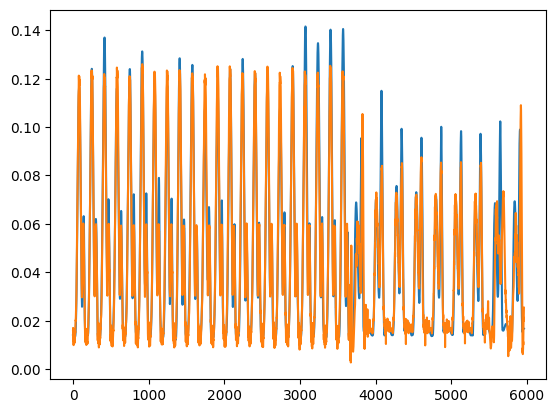

In [41]:
plt.plot(sigTest["Ytarget"][stng["transient"]:,i])
plt.plot(output_net["Y"][i,stng["transient"]:])